# MNIST Handwritten Digit Recognition

The [MNIST](http://yann.lecun.com/exdb/mnist/) problem is a dataset developed by Yann LeCun, Corinna Cortes and Christopher Burges for evaluating machine learning models on the handwritten digit classification problem.

The dataset was constructed from a number of scanned document dataset available from the National Institute of Standards and Technology (NIST). This is where the name for the dataset comes from, as the Modified NIST or MNIST dataset.

Images of digits were taken from a variety of scanned documents, normalized in size and centered. This makes it an excellent dataset for evaluating models, allowing the developer to focus on the machine learning with very little data cleaning or preparation required.

Each image is a 28 by 28 pixel square (784 pixels total). A standard spit of the dataset is used to evaluate and compare models, where 60,000 images are used to train a model and a separate set of 10,000 images are used to test it.

It is a digit recognition task. As such there are 10 digits (0 to 9) or 10 classes to predict. Results are reported using prediction error, which is nothing more than the inverted classification accuracy.

Excellent results achieve a prediction error of less than 1%. State-of-the-art prediction error of approximately 0.2% can be achieved with large Convolutional Neural Networks. There is a listing of the state-of-the-art results and links to the relevant papers on the MNIST and other datasets on [Rodrigo Benenson’s webpage](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354).

This notebook is entirely based on the tutorials from (https://elitedatascience.com/keras-tutorial-deep-learning-in-python) and 
(https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/)

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

## Baseline Model with Multi-Layer Perceptrons

Do we really need a complex model like a convolutional neural network to get the best results with MNIST?

We can get very good results using a very simple neural network model with a single hidden layer. In this section we will create a simple multi-layer perceptron model that achieves an error rate of 1.74%. We will use this as a baseline for comparing more complex convolutional neural network models.

In [3]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

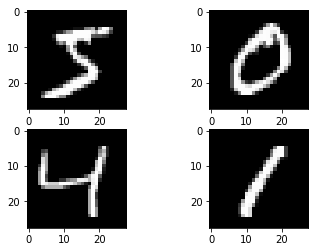

In [4]:
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28

The training dataset is structured as a 3-dimensional array of instance, image width and image height. For a multi-layer perceptron model we must reduce the images down into a vector of pixels. In this case the 28×28 sized images will be 784 pixel input values.

We can do this transform easily using the `reshape()` function on the NumPy array. We can also reduce our memory requirements by forcing the precision of the pixel values to be 32 bit, the default precision used by Keras anyway.

### Preprocess input data for Keras.

In [6]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

The pixel values are gray scale between 0 and 255. It is almost always a good idea to perform some scaling of input values when using neural network models. Because the scale is well known and well behaved, we can very quickly normalize the pixel values to the range 0 and 1 by dividing each value by the maximum of 255.

In [7]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 784)
60000 train samples
10000 test samples


In [8]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

### Preprocess class labels for Keras.

Next, let's take a look at the shape of our class label data:

In [9]:
print(y_train.shape)

(60000,)


That may be problematic. We should have 10 different classes, one for each digit, but it looks like we only have a 1-dimensional array. Let's take a look at the labels for the first 10 training samples:

In [10]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [11]:
# how many unique digits/classes
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [12]:
num_classes = 10

Finally, the output variable is an integer from 0 to 9. This is a multi-class classification problem. As such, it is good practice to use a one hot encoding of the class values, transforming the vector of class integers into a binary matrix.

We can easily do this using the built-in `np_utils.to_categorical()` helper function in Keras.

In [13]:
# one hot encode outputs
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

We are now ready to create our simple multi-layer perceptron model. We will define our model in a function. This is handy if you want to extend the example later and try and get a better score.

In [14]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

The model is a simple neural network with one hidden layer with the same number of neurons as there are inputs (784). A rectifier activation function is used for the neurons in the hidden layer.

A `softmax` activation function is used on the output layer to turn the outputs into probability-like values and allow one class of the 10 to be selected as the model’s output prediction. Logarithmic loss is used as the loss function (called categorical_crossentropy in Keras) and the efficient ADAM gradient descent algorithm is used to learn the weights.

We can now fit and evaluate the model. The model is fit over 10 epochs with updates every 200 images. The test data is used as the validation dataset, allowing us to see the skill of the model as it trains. A verbose value of 2 is used to reduce the output to one line for each training epoch.

Finally, the test dataset is used to evaluate the model and a classification error rate is printed.

In [15]:
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=12, batch_size=128, verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 5s - loss: 0.2527 - acc: 0.9274 - val_loss: 0.1247 - val_acc: 0.9634
Epoch 2/12
60000/60000 [==============================] - 3s - loss: 0.0961 - acc: 0.9718 - val_loss: 0.0818 - val_acc: 0.9741
Epoch 3/12
60000/60000 [==============================] - 2s - loss: 0.0614 - acc: 0.9813 - val_loss: 0.0689 - val_acc: 0.9794
Epoch 4/12
60000/60000 [==============================] - 3s - loss: 0.0418 - acc: 0.9877 - val_loss: 0.0651 - val_acc: 0.9802
Epoch 5/12
60000/60000 [==============================] - 2s - loss: 0.0299 - acc: 0.9910 - val_loss: 0.0676 - val_acc: 0.9787
Epoch 6/12
60000/60000 [==============================] - 2s - loss: 0.0215 - acc: 0.9938 - val_loss: 0.0565 - val_acc: 0.9813
Epoch 7/12
60000/60000 [==============================] - 2s - loss: 0.0154 - acc: 0.9961 - val_loss: 0.0605 - val_acc: 0.9821
Epoch 8/12
60000/60000 [==============================] - 2s 

In [16]:
# Final evaluation of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0761934404124
Test accuracy: 0.9803


## Simple Convolutional Neural Network for MNIST

We need to load the MNIST dataset and reshape it so that it is suitable for use training a CNN.

In [17]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [channels][width][height].

In the case of RGB, the first dimension channel would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In the case of MNIST where the pixel values are gray scale, the pixel dimension is set to 1.

In [18]:
# The keras backend dictates whether channel shouldbe the first dimension or the last. If it's Theano(th) backend then it should be first, 
# otherwise if its Tensorflow(tf) backend t should be last
K.image_data_format()

'channels_last'

In [19]:
# reshape data [samples][channel][width][height]
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols).astype('float32')
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1).astype('float32')
    input_shape = (img_rows, img_cols, 1)

In [20]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


As before, it is a good idea to normalize the pixel values to the range 0 and 1 and one hot encode the output variables.

In [21]:
# normalize inputs from 0-255 to 0-1
X_train /= 255
X_test /= 255

In [22]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Next we define our neural network model.

Convolutional neural networks are more complex than standard multi-layer perceptrons, so we will start by using a simple structure to begin with that uses all of the elements for state of the art results. Below summarizes the network architecture.

1. The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, which with the size of 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [channels][width][height].
2. Next we define a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.
3. The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
4. Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
5. Next a fully connected layer with 128 neurons and rectifier activation function.
6. Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

As before, the model is trained using logarithmic loss and the ADAM gradient descent algorithm.

In [23]:
def baseline_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
# build the model
model = baseline_cnn_model()

We evaluate the model the same way as before with the multi-layer perceptron. The CNN is fit over 12 epochs with a batch size of 128.

In [25]:
batch_size = 128
epochs = 12

# Fit the model
history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=epochs,
          batch_size=batch_size,
          verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 7s - loss: 0.2030 - acc: 0.9407 - val_loss: 0.0651 - val_acc: 0.9793
Epoch 2/12
60000/60000 [==============================] - 6s - loss: 0.0659 - acc: 0.9797 - val_loss: 0.0427 - val_acc: 0.9863
Epoch 3/12
60000/60000 [==============================] - 6s - loss: 0.0458 - acc: 0.9857 - val_loss: 0.0447 - val_acc: 0.9851
Epoch 4/12
60000/60000 [==============================] - 6s - loss: 0.0356 - acc: 0.9887 - val_loss: 0.0361 - val_acc: 0.9878
Epoch 5/12
60000/60000 [==============================] - 6s - loss: 0.0288 - acc: 0.9906 - val_loss: 0.0335 - val_acc: 0.9890
Epoch 6/12
60000/60000 [==============================] - 6s - loss: 0.0238 - acc: 0.9922 - val_loss: 0.0351 - val_acc: 0.9889
Epoch 7/12
60000/60000 [==============================] - 6s - loss: 0.0188 - acc: 0.9938 - val_loss: 0.0329 - val_acc: 0.9890
Epoch 8/12
60000/60000 [==============================] - 6s 

In [26]:
# Final evaluation of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0354700080895
Test accuracy: 0.9895


In [27]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])


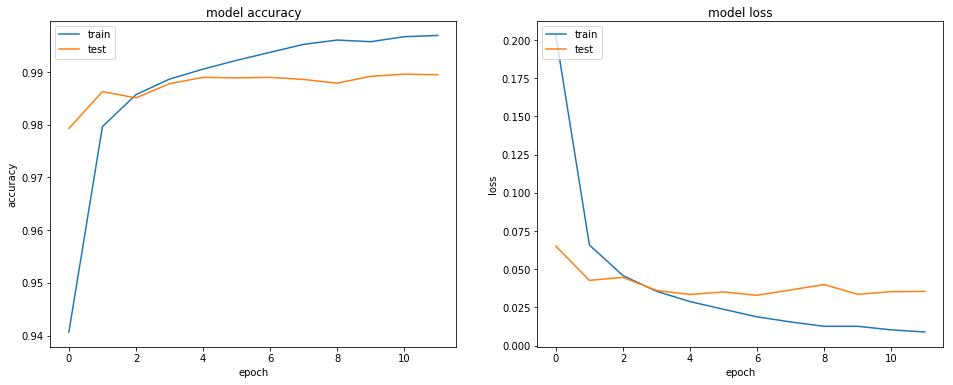

In [28]:
# summarize history for accuracy
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()

# summarize history for loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 592,074
Trainable params: 592,074
Non-trainable params: 0
_________________________________________________________________


## Medium sized Convolutional Neural Network for MNIST

This time we define a medium sized CNN architecture with additional convolutional, max pooling layers and fully connected layers. The network topology can be summarized as follows.

1. Convolutional layer with 32 feature maps of size 3×3.
2. Convolutional layer with 64 feature maps of size 3×3.
2. Pooling layer taking the max over 2*2 patches.
5. Dropout layer with a probability of 25%.
6. Flatten layer.
7. Fully connected layer with 128 neurons and rectifier activation.
5. Dropout layer with a probability of 50%.
9. Output layer with 10 neurons for the 10 classes and a softmax activation function.

The model is trained using logarithmic loss and the AdaDelta gradient descent algorithm.

In [30]:
def medium_cnn_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
    return model

In [31]:
# build the model
model = medium_cnn_model()

In [32]:
batch_size = 128
epochs = 12

# Fit the model
history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=epochs,
          batch_size=batch_size,
          verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 17s - loss: 0.3465 - acc: 0.8939 - val_loss: 0.0825 - val_acc: 0.9749
Epoch 2/12
60000/60000 [==============================] - 17s - loss: 0.1243 - acc: 0.9632 - val_loss: 0.0573 - val_acc: 0.9814
Epoch 3/12
60000/60000 [==============================] - 17s - loss: 0.0922 - acc: 0.9722 - val_loss: 0.0457 - val_acc: 0.9850
Epoch 4/12
60000/60000 [==============================] - 17s - loss: 0.0754 - acc: 0.9775 - val_loss: 0.0394 - val_acc: 0.9865
Epoch 5/12
60000/60000 [==============================] - 17s - loss: 0.0673 - acc: 0.9805 - val_loss: 0.0346 - val_acc: 0.9879
Epoch 6/12
60000/60000 [==============================] - 17s - loss: 0.0577 - acc: 0.9830 - val_loss: 0.0320 - val_acc: 0.9896
Epoch 7/12
60000/60000 [==============================] - 17s - loss: 0.0529 - acc: 0.9846 - val_loss: 0.0314 - val_acc: 0.9891
Epoch 8/12
60000/60000 [==============================

In [33]:
# Final evaluation of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0279900544693
Test accuracy: 0.9904


In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

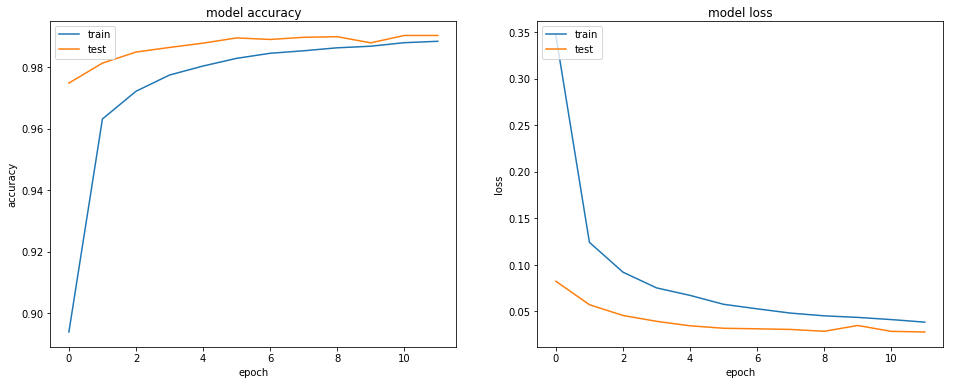

In [35]:
# summarize history for accuracy
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()

# summarize history for loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Larger Convolutional Neural Network for MNIST

Now that we have seen how to create a simple CNN, let’s take a look at a model capable of close to state of the art results.

This time we define a large CNN architecture with additional convolutional, max pooling layers and fully connected layers. The network topology can be summarized as follows.

1. Convolutional layer with 30 feature maps of size 5×5.
2. Pooling layer taking the max over 2*2 patches.
3. Convolutional layer with 15 feature maps of size 3×3.
4. Pooling layer taking the max over 2*2 patches.
5. Dropout layer with a probability of 20%.
6. Flatten layer.
7. Fully connected layer with 128 neurons and rectifier activation.
8. Fully connected layer with 50 neurons and rectifier activation.
9. Output layer with 10 neurons for the 10 classes and a softmax activation function.

In [36]:
def larger_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(filters=30, kernel_size=(5, 5), strides=(1,1),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [37]:
# build the model
model = larger_cnn_model()

In [38]:
batch_size = 128
epochs = 12

# Fit the model
history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=epochs,
          batch_size=batch_size,
          verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 7s - loss: 0.3012 - acc: 0.9075 - val_loss: 0.0631 - val_acc: 0.9800
Epoch 2/12
60000/60000 [==============================] - 6s - loss: 0.0829 - acc: 0.9746 - val_loss: 0.0451 - val_acc: 0.9863
Epoch 3/12
60000/60000 [==============================] - 6s - loss: 0.0632 - acc: 0.9803 - val_loss: 0.0378 - val_acc: 0.9872
Epoch 4/12
60000/60000 [==============================] - 6s - loss: 0.0515 - acc: 0.9844 - val_loss: 0.0349 - val_acc: 0.9888
Epoch 5/12
60000/60000 [==============================] - 6s - loss: 0.0436 - acc: 0.9863 - val_loss: 0.0286 - val_acc: 0.9906
Epoch 6/12
60000/60000 [==============================] - 6s - loss: 0.0380 - acc: 0.9880 - val_loss: 0.0292 - val_acc: 0.9903
Epoch 7/12
60000/60000 [==============================] - 6s - loss: 0.0335 - acc: 0.9889 - val_loss: 0.0253 - val_acc: 0.9922
Epoch 8/12
60000/60000 [==============================] - 6s 

In [39]:
# Final evaluation of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0249372907208
Test accuracy: 0.9916


In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 30)        780       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 15)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 375)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               48128     
__________

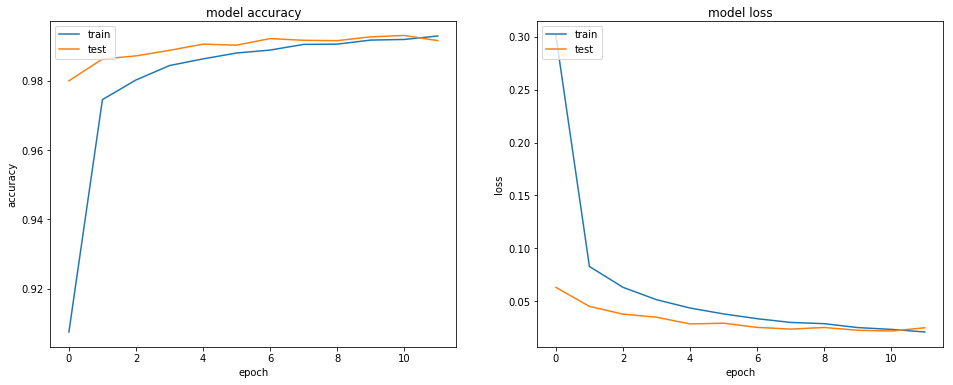

In [41]:
# summarize history for accuracy
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()

# summarize history for loss
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()